________________________________________________________________________________
[Memory] Calling sklearn.cluster.hierarchical.ward_tree...
ward_tree(array([[-0.451933, ..., -0.675318],
       ...,
       [ 0.275706, ..., -1.085711]]), 
<1600x1600 sparse matrix of type '<class 'numpy.int32'>'
	with 7840 stored elements in COOrdinate format>, n_clusters=None, return_distance=False)
________________________________________________________ward_tree - 0.1s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.cluster.hierarchical.ward_tree...
ward_tree(array([[ 0.905206, ...,  0.161245],
       ...,
       [-0.849835, ..., -1.091621]]), 
<1600x1600 sparse matrix of type '<class 'numpy.int32'>'
	with 7840 stored elements in COOrdinate format>, n_clusters=None, return_distance=False)
________________________________________________________ward_tree - 0.1s, 0.0min
______________________________________________________________________

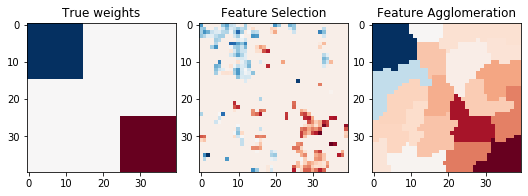

In [2]:
#https://scikit-learn.org/stable/auto_examples/cluster/plot_feature_agglomeration_vs_univariate_selection.html#sphx-glr-auto-examples-cluster-plot-feature-agglomeration-vs-univariate-selection-py
import shutil
import tempfile

import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg, ndimage
from joblib import Memory

from sklearn.feature_extraction.image import grid_to_graph
from sklearn import feature_selection
from sklearn.cluster import FeatureAgglomeration
from sklearn.linear_model import BayesianRidge
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

n_samples = 200
size = 40  # image size
roi_size = 15
snr = 5.
np.random.seed(0)
mask = np.ones([size, size], dtype=np.bool)

coef = np.zeros((size, size))
coef[0:roi_size, 0:roi_size] = -1.
coef[-roi_size:, -roi_size:] = 1.

X = np.random.randn(n_samples, size ** 2)
for x in X:  # smooth data
    x[:] = ndimage.gaussian_filter(x.reshape(size, size), sigma=1.0).ravel()
X -= X.mean(axis=0)
X /= X.std(axis=0)

y = np.dot(X, coef.ravel())
noise = np.random.randn(y.shape[0])
noise_coef = (linalg.norm(y, 2) / np.exp(snr / 20.)) / linalg.norm(noise, 2)
y += noise_coef * noise  # add noise

cv = KFold(2)
ridge = BayesianRidge()
cachedir = tempfile.mkdtemp()
mem = Memory(location=cachedir, verbose=1)

connectivity = grid_to_graph(n_x=size, n_y=size)
ward = FeatureAgglomeration(n_clusters=10, connectivity=connectivity,
                            memory=mem)
clf = Pipeline([('ward', ward), ('ridge', ridge)])
clf = GridSearchCV(clf, {'ward__n_clusters': [10, 20, 30]}, n_jobs=1, cv=cv)
clf.fit(X, y)  # set the best parameters
coef_ = clf.best_estimator_.steps[-1][1].coef_
coef_ = clf.best_estimator_.steps[0][1].inverse_transform(coef_)
coef_agglomeration_ = coef_.reshape(size, size)

f_regression = mem.cache(feature_selection.f_regression)  # caching function
anova = feature_selection.SelectPercentile(f_regression)
clf = Pipeline([('anova', anova), ('ridge', ridge)])
clf = GridSearchCV(clf, {'anova__percentile': [5, 10, 20]}, cv=cv)
clf.fit(X, y)  # set the best parameters
coef_ = clf.best_estimator_.steps[-1][1].coef_
coef_ = clf.best_estimator_.steps[0][1].inverse_transform(coef_.reshape(1, -1))
coef_selection_ = coef_.reshape(size, size)

plt.close('all')
plt.figure(figsize=(7.3, 2.7))
plt.subplot(1, 3, 1)
plt.imshow(coef, interpolation="nearest", cmap=plt.cm.RdBu_r)
plt.title("True weights")
plt.subplot(1, 3, 2)
plt.imshow(coef_selection_, interpolation="nearest", cmap=plt.cm.RdBu_r)
plt.title("Feature Selection")
plt.subplot(1, 3, 3)
plt.imshow(coef_agglomeration_, interpolation="nearest", cmap=plt.cm.RdBu_r)
plt.title("Feature Agglomeration")
plt.subplots_adjust(0.04, 0.0, 0.98, 0.94, 0.16, 0.26)
plt.show()

shutil.rmtree(cachedir, ignore_errors=True)